# Identify The Sentiments

#### Overview:
            Sentiment analysis is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. It is the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.Sentiment analysis allows businesses to identify customer sentiment toward products, brands or services in online conversations and feedback.I took this Dataset from one of the Analytics Vidya Data science Competition named as 'Identify the Sentiments;

#### Problem Statement:
           the task is to identify if the tweets have a negative sentiment or positive by applying some text analytics on 
           text data
#### Content:
           

### Importing necessary Libraries

In [247]:
import pandas as pd
import numpy as np
import string
import re
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from dict import emoticons,UNICODE_EMO,EMOTICONS_EMO,chat_words

In [248]:
# IMPORTING MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC,SVC
# IMPORTING SCORING PARAMETERS
from sklearn.metrics import *
from sklearn.model_selection import *
from imblearn.over_sampling import SMOTE

In [249]:
#import libraries for text Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.figure_factory as ff

### Load Data

In [250]:
train=pd.read_csv('data/train_tweet.csv')
test=pd.read_csv('data/test_tweet.csv')

### Data Exploration
      In this section, we will begin exploring the data through visualizations and code to understand how data is 
      distributed. 

In [251]:
train.tail() #show the last 5 roes of train data

,id,label,tweet
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...
7919,7920,0,Apple Barcelona!!! #Apple #Store #BCN #Barcelo...


In [252]:
test.head() #show first 5 rows of test data

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [253]:
#no of observation in both train and test data
print(train.shape)
print(test.shape)

(7920, 3)
(1953, 2)


In [254]:
train.describe(include=np.object)

,tweet
count,7920
unique,7918
top,@architecture_3design - TAG YOUR FRIENDS @arch...
freq,3


     There are duplicates tweet present in the data ,Since duplicate tweets don't give much information to data ,then we 
     need to remove this by using drop_duplicates() method

In [255]:
train.drop_duplicates(inplace=True,subset='tweet')

In [256]:
train.describe(include=np.object)

,tweet
count,7918
unique,7918
top,Yet another pair of apple headphones bite the ...
freq,1


In [257]:
# show th label distribution of tweets
temp=train.groupby(['label']).count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet
0,0,5892
1,1,2026


In [258]:
#funnel chart
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

     Here we can see that there are more positive tweet(75%) than negative tweet(25%) , which brings the ratio of 3:1.This        indicates that this dataset is an Imbalance dataset.Let's examine the behaviour of tweets

In [259]:
#create function to claculate no of words in sentence and length of a sentence
def no_of_words(sentence):
    words=[w for w in str(sentence).split()]
    return len(words)
def length_of_sentence(
    sentence):
    return len(str(sentence))

In [260]:
train['no of words']=train['tweet'].apply(no_of_words)
train['length of tweet']=train['tweet'].apply(length_of_sentence)

In [261]:
#Divide the data into two groups based 
negative=train[train.label==1]
positive=train[train.label==0]

In [262]:
list(negative['tweet'])

["What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!",
 'iPhone software update fucked up my phone big time Stupid iPhones',
 'hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.',
 'Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade',
 'Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo',
 '@shaqlockholmes @sam_louise1991 the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.',
 "The reason I don't have one. #iphone #suck #apple #truth #truthbetold #agree #fact #realitycheck #blackberrypic.twitter.com/zpggd7caZN",
 "How is the apple store gunna be out of 5C screens ?!? It's Monday and ur the FUCKING APPLE STORE !!! #fuckingpissed",
 "I've had this new ipod for four

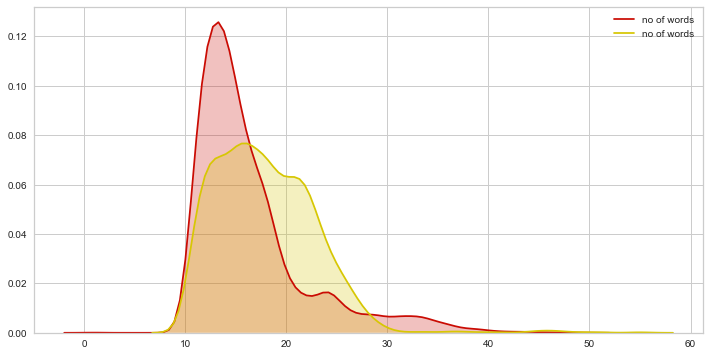

In [263]:
plt.figure(figsize=(12,6))
sns.kdeplot(positive['no of words'],shade=True,color='r')
sns.kdeplot(negative['no of words'],shade=True,color='y')

     We can see that most of the positive tweet have 10-20 words while negative tweets is between 10-30 , which is not a            drastic difference

## Text preprocessing

    The first thing that we'll do is preprocess the tweets so that they're easier to deal with, and ready for feature extraction, and training by the classifiers
 
     
     Then for the preprocessing, we'll:
          1.Convert tweet into lower case letters
          2.Remove URL
          3. Remove HTML tags
          4.Convert all emoji and emoticons into text format
          5.Replace contractions  with respective full form
          6.Since there may be chart words in the data .So we need to replace them with meaningfull word
          7.Clean tweet data
          8. Remove Punctuations which are not ncessary for further analysis
          9.Spelling Correction
          10. Remove stopwords
          11.Stemming the tweet data 

In [264]:
train.shape

(7918, 5)

#### 1.Lowercasing
      Lowercasing is the basic step of text preprocessing .It helps to consider Text,TEXT,text  as same word.It is an 
      essential step

In [265]:
train['tweet']=train['tweet'].str.lower()

In [266]:
train.head()

,id,label,tweet,no of words,length of tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...,13,128
1,2,0,finally a transparant silicon case ^^ thanks t...,17,131
2,3,0,we love this! would you go? #talk #makememorie...,15,123
3,4,0,i'm wired i know i'm george i was made that wa...,17,112
4,5,1,what amazing service! apple won't even talk to...,23,124


#### 2.Remove URL
     In tweeter most of the people use URL for website reference , which contain meaningless information .So we need to 
     remove these to convert messy data into clean one

In [267]:
def remove_url(text):
     #clean URL
    text=re.sub(r'https?://\S+|www\.\S+', '', text) 
    return text

In [268]:
train['clean_tweet']=train['tweet'].apply(remove_url)

#### 3.Remove HTML tags

In [269]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [270]:
train['clean_tweet']=train['clean_tweet'].apply(remove_html)

In [271]:
list(train['clean_tweet'])

['#fingerprint #pregnancy test  #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone',
 'finally a transparant silicon case ^^ thanks to my uncle :) #yay #sony #xperia #s #sonyexperias… ',
 'we love this! would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... ',
 "i'm wired i know i'm george i was made that way ;) #iphone #cute #daventry #home ",
 "what amazing service! apple won't even talk to me about a question i have unless i pay them $19.95 for their stupid support!",
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. #instapic #instadaily #us #sony #xperia #xperiaz ',
 'new type c charger cable #uk  … #bay #amazon #etsy new year #rob cross #toby young #evemun #mcmafia #taylor #spectre 2018 #newyear #starting 2018 #recipes #technology #samsunggalaxys9 #iphonex pic.twitter.com/pjiwq59wtc',
 'bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow… 

#### 4.Convert emoticons and emoji  to word

    With more and more usage of social media platforms, there is an explosion in the usage of emojis in our day to day       as well. In case of use cases like sentiment analysis, the emoticons give some valuable information  so instead of 
    removing them converting them into informative word may be a good solution.In clean tweet of train dataset emoticons are present .So let's convert them into meaningful info.
    
    One way is to convert the emoticons to word format so that they can be used in downstream modeling processes.We have a 
    list of emoji and emoticons and their respective words in UNICODE_EMO and emoticons dictionary. We are going to use this conversion of emoticons to words.

In [272]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

def convert_emoticons(text):
    for emot in emoticons:
        text = re.sub(u'('+emot+')', "_".join(emoticons[emot].replace(",","").split()), text)
    return text

In [273]:
train['clean_tweet']=train['clean_tweet'].apply(convert_emoticons)

In [274]:
list(train['tweet'])

['#fingerprint #pregnancy test https://goo.gl/h1mfqv #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone',
 'finally a transparant silicon case ^^ thanks to my uncle :) #yay #sony #xperia #s #sonyexperias… http://instagram.com/p/yget5jc6jm/',
 'we love this! would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6n3lsupcu',
 "i'm wired i know i'm george i was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/li_5_ujs4k/",
 "what amazing service! apple won't even talk to me about a question i have unless i pay them $19.95 for their stupid support!",
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. #instapic #instadaily #us #sony #xperia #xperiaz https://instagram.com/p/z9qgfwlvj7/',
 'new type c charger cable #uk http://www.ebay.co.uk/itm/-/112598674021 … #bay #amazon #etsy new year #rob cross #toby young #evemun #mcmafia #taylor #spectre 2018 #newyear #starting

In [275]:
list(train['clean_tweet'])

['#fingerprint #pregnancy test  #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone',
 'finally a transparant silicon case ^^ thanks to my uncle Happy_face_or_smiley #yay #sony #xperia #s #sonyexperias… ',
 'we love this! would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... ',
 "i'm wired i know i'm george i was made that way Wink_or_smirk #iphone #cute #daventry #home ",
 "what amazing service! apple won't even talk to me about a question i have unless i pay them $19.95 for their stupid support!",
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. #instapic #instadaily #us #sony #xperia #xperiaz ',
 'new type c charger cable #uk  … #bay #amazon #etsy new year #rob cross #toby young #evemun #mcmafia #taylor #spectre 2018 #newyear #starting 2018 #recipes #technology #samsunggalaxys9 #iphonex pic.twitter.com/pjiwq59wtc',
 'bout to go shopping again listening to music #iphone #justme #music #l

#### 5.Replace Contractions
     We usually use contractions in english word .But machine can not understand those contraction .So we need to convert 
     them into it's full form

In [276]:
cList = {"ain't": "am not","aren't": "are not","can't": "can not","can't've": "can not have", "'cause": "because",
         "could've": "could have", "couldn't": "could not","couldn't've": "could not have","didn't": "did not",
         "doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have","he'll": "he will","he'll've": "he will have",
         "he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","i'd": "i would",
         "i'd've": "i would have", "i'll": "i will","i'll've": "i will have", "i'm": "i am","i've": "i have","isn't": "is not",
         "it'd": "it had","it'd've": "it would have","it'll": "it will","it'll've": "it will have",  "it's": "it is",
         "let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
         "mightn't've": "might not have","must've": "must have", "mustn't": "must not","mustn't've": "must not have",
         "needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
         "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
         "she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
         "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
         "so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had",
         "there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
         "they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
         "wasn't": "was not","we'd": "we had","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
         "we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have",
         "what're": "what are","what's": "what is","what've": "what have","when's": "when is", "when've": "when have",
         "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have",
         "who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not",
         "won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
         "y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have",
         "y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have",
         "you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have","wouldn":"would not"
}

In [277]:
def expandContractions(tweet):
    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [cList[word] if word in cList else word for word in words]
    tweet = " ".join(reformed)
    return tweet

In [278]:
train['clean_tweet']=train['clean_tweet'].apply(expandContractions)

In [279]:
train.head(15)

,id,label,tweet,no of words,length of tweet,clean_tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...,13,128,#fingerprint #pregnancy test #android #apps #b...
1,2,0,finally a transparant silicon case ^^ thanks t...,17,131,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...,15,123,we love this! would you go? #talk #makememorie...
3,4,0,i'm wired i know i'm george i was made that wa...,17,112,i am wired i know i am george i was made that ...
4,5,1,what amazing service! apple won't even talk to...,23,124,what amazing service! apple will not even talk...
5,6,1,iphone software update fucked up my phone big ...,11,65,iphone software update fucked up my phone big ...
6,7,0,happy for us .. #instapic #instadaily #us #son...,11,100,happy for us .. #instapic #instadaily #us #son...
7,8,0,new type c charger cable #uk http://www.ebay.c...,30,259,new type c charger cable #uk … #bay #amazon #e...
8,9,0,bout to go shopping again listening to music #...,14,130,bout to go shopping again listening to music #...
9,10,0,photo: #fun #selfie #pool #water #sony #camera...,14,128,photo: #fun #selfie #pool #water #sony #camera...


#### 6.Chat word Conversion
    This is an important text preprocessing step if we are dealing with chat data. People do use a lot of abbreviated words in chat and so it might be helpful to expand those words for our analysis purposes.
    all the possible chat word and their respective meaning has been stored in chat_words dictionary

In [280]:
chat_word_list=[]
chat_word_dict={}
for line in chat_words.split("\n"):
    if line !="":
        short_form=line.split("=")[0]
        full_form=line.split("=")[1]
        chat_word_list.append(short_form)
        chat_word_dict[short_form]=full_form
chat_word_list=set(chat_word_list)

def chart_word_conversion(text):
    new_text=[]
    for word in text.split():
        if word.upper() in chat_word_list:
            new_text.append(chat_word_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)        

In [281]:
train['clean_tweet']=train['clean_tweet'].apply(chart_word_conversion)
train.head(15)

,id,label,tweet,no of words,length of tweet,clean_tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...,13,128,#fingerprint #pregnancy test #android #apps #b...
1,2,0,finally a transparant silicon case ^^ thanks t...,17,131,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...,15,123,we love this! would you go? #talk #makememorie...
3,4,0,i'm wired i know i'm george i was made that wa...,17,112,i am wired i know i am george i was made that ...
4,5,1,what amazing service! apple won't even talk to...,23,124,what amazing service! apple will not even talk...
5,6,1,iphone software update fucked up my phone big ...,11,65,iphone software update fucked up my phone big ...
6,7,0,happy for us .. #instapic #instadaily #us #son...,11,100,happy for us .. #instapic #instadaily #us #son...
7,8,0,new type c charger cable #uk http://www.ebay.c...,30,259,new type c charger cable #uk … #bay #amazon #e...
8,9,0,bout to go shopping again listening to music #...,14,130,bout to go shopping again listening to music #...
9,10,0,photo: #fun #selfie #pool #water #sony #camera...,14,128,photo: #fun #selfie #pool #water #sony #camera...


#### 7.Text Cleaning
     In tweet data we can find stock market stickers, old style Retweet which we don't need.So remove them.
     In this step we will remove URl,emails,user mentions,hashtags and number

In [282]:
def clean_text(text):
    text=str(text)
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # clean email
    text=re.sub(r'[\w\.\-\_]+@[\w\.\-\_]+\.[a-z]+', '',text)# clean email
    #remove @user mention
    text=re.sub(r"@[A-Za-z0-9_]+",'', text) 
    text=re.sub(r"#",'',text)
    text = re.sub(r'\d+', '', text)
    return text

In [283]:
train['clean_tweet']=train['clean_tweet'].apply(clean_text)

In [284]:
train.head(15)

,id,label,tweet,no of words,length of tweet,clean_tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...,13,128,fingerprint pregnancy test android apps beauti...
1,2,0,finally a transparant silicon case ^^ thanks t...,17,131,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...,15,123,we love this! would you go? talk makememories ...
3,4,0,i'm wired i know i'm george i was made that wa...,17,112,i am wired i know i am george i was made that ...
4,5,1,what amazing service! apple won't even talk to...,23,124,what amazing service! apple will not even talk...
5,6,1,iphone software update fucked up my phone big ...,11,65,iphone software update fucked up my phone big ...
6,7,0,happy for us .. #instapic #instadaily #us #son...,11,100,happy for us .. instapic instadaily us sony xp...
7,8,0,new type c charger cable #uk http://www.ebay.c...,30,259,new type c charger cable uk … bay amazon etsy ...
8,9,0,bout to go shopping again listening to music #...,14,130,bout to go shopping again listening to music i...
9,10,0,photo: #fun #selfie #pool #water #sony #camera...,14,128,photo: fun selfie pool water sony camera picof...


In [285]:
list(train['clean_tweet'])

['fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone',
 'finally a transparant silicon case ^^ thanks to my uncle Happy_face_or_smiley yay sony xperia s sonyexperias…',
 'we love this! would you go? talk makememories unplug relax iphone smartphone wifi connect...',
 'i am wired i know i am george i was made that way Wink_or_smirk iphone cute daventry home',
 'what amazing service! apple will not even talk to me about a question i have unless i pay them . for their stupid support!',
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. instapic instadaily us sony xperia xperiaz',
 'new type c charger cable uk … bay amazon etsy new year rob cross toby young evemun mcmafia taylor spectre  newyear starting  recipes technology samsunggalaxys iphonex pic.twitter.com/pjiwqwtc',
 'bout to go shopping again listening to music iphone justme music likeforlike followforfollow…',
 'photo: fun selfie pool water sony camer

    There are lots of pic.twitter.com\* in this data .So we need to remove this also.

In [286]:
def extra(text):
    text=re.sub(r'\w+\.twitter\.com\/\w+','',text)
    return text

In [287]:
train['clean_tweet']=train['clean_tweet'].apply(extra)

In [288]:
list(train['clean_tweet'])

['fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone',
 'finally a transparant silicon case ^^ thanks to my uncle Happy_face_or_smiley yay sony xperia s sonyexperias…',
 'we love this! would you go? talk makememories unplug relax iphone smartphone wifi connect...',
 'i am wired i know i am george i was made that way Wink_or_smirk iphone cute daventry home',
 'what amazing service! apple will not even talk to me about a question i have unless i pay them . for their stupid support!',
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. instapic instadaily us sony xperia xperiaz',
 'new type c charger cable uk … bay amazon etsy new year rob cross toby young evemun mcmafia taylor spectre  newyear starting  recipes technology samsunggalaxys iphonex ',
 'bout to go shopping again listening to music iphone justme music likeforlike followforfollow…',
 'photo: fun selfie pool water sony camera picoftheday sun instag

#### 8.Remove punctuation
      One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way.

      We also need to carefully choose the list of punctuations to exclude depending on the use case.In this case we convert all the emoticons into twxt format.For Ex :-   :) becomes Happy_face_or_smiley .So if we remove "-" from this word  then it become Happyfaceorsmiley which lose its meaning.So I remove  "_" from list of punctuation !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`


In [289]:
punctuation=string.punctuation
punctuation.replace('_',"")
def remove_punctuation(text):
    token=word_tokenize(text)
    word=[w for w in token if not w in punctuation]
    text=" ".join(word)
    return text

In [290]:
train['clean_tweet']=train['clean_tweet'].apply(remove_punctuation)


In [291]:
list(train['tweet'])

['#fingerprint #pregnancy test https://goo.gl/h1mfqv #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone',
 'finally a transparant silicon case ^^ thanks to my uncle :) #yay #sony #xperia #s #sonyexperias… http://instagram.com/p/yget5jc6jm/',
 'we love this! would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6n3lsupcu',
 "i'm wired i know i'm george i was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/li_5_ujs4k/",
 "what amazing service! apple won't even talk to me about a question i have unless i pay them $19.95 for their stupid support!",
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. #instapic #instadaily #us #sony #xperia #xperiaz https://instagram.com/p/z9qgfwlvj7/',
 'new type c charger cable #uk http://www.ebay.co.uk/itm/-/112598674021 … #bay #amazon #etsy new year #rob cross #toby young #evemun #mcmafia #taylor #spectre 2018 #newyear #starting

In [292]:
list(train['clean_tweet'])

['fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone',
 'finally a transparant silicon case ^^ thanks to my uncle Happy_face_or_smiley yay sony xperia s sonyexperias…',
 'we love this would you go talk makememories unplug relax iphone smartphone wifi connect ...',
 'i am wired i know i am george i was made that way Wink_or_smirk iphone cute daventry home',
 'what amazing service apple will not even talk to me about a question i have unless i pay them for their stupid support',
 'iphone software update fucked up my phone big time stupid iphones',
 'happy for us .. instapic instadaily us sony xperia xperiaz',
 'new type c charger cable uk … bay amazon etsy new year rob cross toby young evemun mcmafia taylor spectre newyear starting recipes technology samsunggalaxys iphonex',
 'bout to go shopping again listening to music iphone justme music likeforlike followforfollow…',
 'photo fun selfie pool water sony camera picoftheday sun instagood boy c



Here we can see that we are unable to remove consucative punctuations.So for this i implement another function named as remove_succesive_punctuation

In [293]:
def remove_succesive_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punctuation))

In [294]:
train['clean_tweet']=train['clean_tweet'].apply(remove_succesive_punctuation)

#### 9.Spelling Correction
     One another important text preprocessing step is spelling correction.Typos are common in text data and we might want to correct those spelling mistakes before we do our analysis.
     In this notebook, let us use the python package pyspellchecker for our spelling correction

In [295]:
from spellchecker import SpellChecker
spell=SpellChecker()
def spelling_correction(text):
    new_text=[]
    misspell=spell.unknown(text.split())
    for word in text.split():
        if word in misspell:
            new_text.append(spell.correction(word))
        else:
            new_text.append(word)
    return " ".join(new_text)        

#### 10.Remove  Unnecessary word(Stop words)
     Stopwords are commonly occuring words in a language like 'the', 'a' and so on.They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis.For sentiment analysis not word gives the polarity of the word .
     for ex: I did not like the match(negative)
             I like the match (positive)
     By just removing not word both sentence give same sentiment .So it's crucial to not include not related stopwords.

In [296]:
verb=['i','be','am','are','can','could','have','had','did','does','do','has','would','will','is','he','may','might','must','need',
      'ought','shall','should','were','you','i','me','my','myself','we','our','ours','ourselves','you',"you're","you've",
      "you'll","you'd",'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself',
      'it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that',
      "that'll",'these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does',
      'did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about',
      'against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on',
      'off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each',
      'few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can',
      'will','just','should',"should've",'now','d','ll','m','o','re','ve','y',]
sentiment_stopwords=set(verb)

In [297]:
def important_words(text):
    word_token=[ word for word in text.split()]
    text_clean = []
    for word in word_token:
        if (word not in sentiment_stopwords):
            text_clean.append(word) 
    return " ".join(text_clean)

In [298]:
train['clean_tweet']=train['clean_tweet'].apply(important_words)

In [299]:
train.head(15)

,id,label,tweet,no of words,length of tweet,clean_tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...,13,128,fingerprint pregnancy test android apps beauti...
1,2,0,finally a transparant silicon case ^^ thanks t...,17,131,finally transparant silicon case thanks uncle ...
2,3,0,we love this! would you go? #talk #makememorie...,15,123,love go talk makememories unplug relax iphone ...
3,4,0,i'm wired i know i'm george i was made that wa...,17,112,wired know george made way Winkorsmirk iphone ...
4,5,1,what amazing service! apple won't even talk to...,23,124,amazing service apple even talk question unles...
5,6,1,iphone software update fucked up my phone big ...,11,65,iphone software update fucked phone big time s...
6,7,0,happy for us .. #instapic #instadaily #us #son...,11,100,happy us instapic instadaily us sony xperia xp...
7,8,0,new type c charger cable #uk http://www.ebay.c...,30,259,new type c charger cable uk … bay amazon etsy ...
8,9,0,bout to go shopping again listening to music #...,14,130,bout go shopping listening music iphone justme...
9,10,0,photo: #fun #selfie #pool #water #sony #camera...,14,128,photo fun selfie pool water sony camera picoft...


#### 11.Stemming

     Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form (From Wikipedia)
     For example, if there are two words in the corpus talks and talking, then stemming will stem the suffix to make them 
     talk. But say in another example, we have two words console and consoling, the stemmer will remove the suffix and make          them consol which is not a proper english word.

In [300]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
def stemming(text):
    tokens=word_tokenize(text)
    new_set=[]
    for word in tokens:
        new_set.append(stemmer.stem(word))
    return " ".join(new_set)    

In [301]:
train['clean_tweet']=train['clean_tweet'].apply(stemming)

In [302]:
list(train['clean_tweet'])

['fingerprint pregnanc test android app beauti cute health iger iphoneonli iphonesia iphon',
 'final transpar silicon case thank uncl happyfaceorsmiley yay soni xperia sonyexperias…',
 'love go talk makememori unplug relax iphon smartphon wifi connect',
 'wire know georg made way winkorsmirk iphon cute daventri home',
 'amaz servic appl even talk question unless pay stupid support',
 'iphon softwar updat fuck phone big time stupid iphon',
 'happi us instap instadaili us soni xperia xperiaz',
 'new type c charger cabl uk … bay amazon etsi new year rob cross tobi young evemun mcmafia taylor spectr newyear start recip technolog samsunggalaxi iphonex',
 'bout go shop listen music iphon justm music likeforlik followforfollow…',
 'photo fun selfi pool water soni camera picoftheday sun instagood boy cute outdoor',
 'hey appl make new ipod dont make new color inch thinner make crash everi five fuckin minit',
 'ha heavi machineri realli drop ball design drinkyourhaterad',
 'contempl give iphon 

#### Frequency of words

In [303]:
from collections import Counter
cnt = Counter()
for text in train['clean_tweet'].values:
    for word in text.split():
        cnt[word] += 1


#### Remove Frequent Word

In [304]:
cnt.most_common(10)

[('iphon', 4087),
 ('appl', 2852),
 ('samsung', 1390),
 ('new', 1138),
 ('phone', 1016),
 ('follow', 888),
 ('…', 836),
 ('soni', 812),
 ('ipad', 538),
 ('rt', 533)]

In [305]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

train['clean_tweet']= train['clean_tweet'].apply(lambda text: remove_freqwords(text))

#### Remove rare word

In [306]:
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
def remove_rarewords(text):

    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

train['clean_tweet']= train['clean_tweet'].apply(lambda text: remove_freqwords(text))

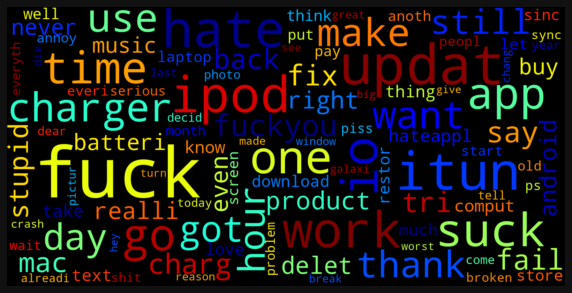

In [307]:
allWords = ' '.join([twts for twts in train[train['label']==1]['clean_tweet']])
wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=200,colormap='jet',max_words=100).generate(allWords)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

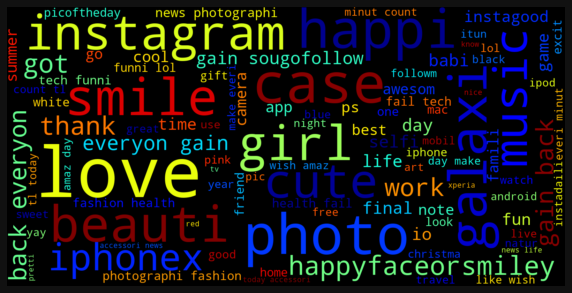

In [308]:
allWords = ' '.join([twts for twts in train[train['label']==0]['clean_tweet']])
wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=200,colormap='jet',max_words=100).generate(allWords)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Text Preparation

In [309]:
smote=SMOTE()# library for over sampling

### Feature Extraction

#### TF-IDF Features

    TF-IDF representation, also called the TF-IDF model, takes into the account the importance of each word. This also known as "Term Frequency-Inverse Document".TF-IDF  are word frequency that highlits the word that are more interesting.
        Term Frequency: This summarizes how often a given word appears within a document.
        Inverse Document Frequency: This downscales words that appear a lot across documents.
        
        tf(t,d)= frequency of term t in document d/ no of terms in document d
        idf(t)=log(total no of document/total no of document that have t)

In [310]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                     ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words = 'english')
vect.fit(list(train.clean_tweet.values))
train_clean_tweet=vect.transform(list(train.clean_tweet.values))

In [311]:
print("Length of Vocabulary:", len(vect.vocabulary_))
print("Shape of Train Data:", train_clean_tweet.shape)

Length of Vocabulary: 6287
Shape of Train Data: (7918, 6287)


In [312]:
#over-sample this imbalance dataset
tweet_sample,label_sample=smote.fit_sample(train_clean_tweet,list(train.label.values))

In [313]:
#split sample datd into train ,test,set
xtrain_tfidf,xtest_tfidf,ytrain_tfidf,ytest_tfidf=train_test_split(tweet_sample,label_sample,stratify=label_sample, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

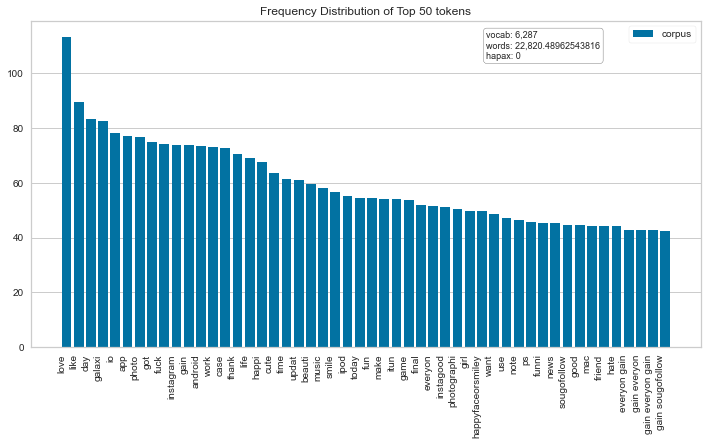

In [314]:
from yellowbrick.text import FreqDistVisualizer

features   = vect.get_feature_names()
fig, ax = plt.subplots(figsize=(12,6))
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(train_clean_tweet)
visualizer.show()

### CountVectorizer
     An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

In [315]:
from sklearn.feature_extraction.text import CountVectorizer
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english',max_features=2500)
ctv.fit(list(train.clean_tweet.values))
train_clean_tweet_ctv=ctv.transform(list(train.clean_tweet.values))

In [316]:
tweet_sample_ctv,label_sample_ctv=smote.fit_sample(train_clean_tweet_ctv,list(train.label.values))

In [317]:
xtrain_ctv,xtest_ctv,ytrain_ctv,ytest_ctv=train_test_split(tweet_sample_ctv,label_sample_ctv,stratify=label_sample_ctv, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

## Hyperparameter Tuning

In [318]:
#function for RandomizedSearchCV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=777)
scoring = {
        'accuracy': make_scorer(accuracy_score),
        'sensitivity/recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'f1':make_scorer(f1_score),
        'Mcc':make_scorer(matthews_corrcoef)
        }
#since evaluation metric was 'F1_weighted' .So we use f1_weighted as scoring metrics
def tuning(estimator,parameter,X,y):
    tune_model=RandomizedSearchCV(estimator=estimator,
                                      param_distributions=parameter,
                                      n_iter=100,cv=kfold,verbose=2,
                                      random_state=42,n_jobs=-1,refit=True,scoring="f1_weighted")
    tune_model.fit(X,y)
    return tune_model

## Model Evaluation

In [319]:
#function to evaluate the classification model
def metrics(test,prediction):
    return confusion_matrix(test,prediction,[0,1]),classification_report(test,prediction),f1_score(test,prediction,average='weighted')

In [320]:
#function to draw roc_auc_curve
def curve(test,prediction):
    fpr, tpr, thresholds = roc_curve(test, prediction)
    auc_ = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=' (area = {:.3f})'.format(auc_))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

## Model for TFIDF

### Logistic Regression

In [321]:
clf1=LogisticRegression()
param1={'C':[0.001,0.01,0.1,1,10,100]}
log_reg=tuning(clf1,param1,xtrain_tfidf,ytrain_tfidf)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.5s finished
C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [322]:
result=pd.DataFrame(log_reg.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151035,0.105974,0.005684,0.000897,0.001,{'C': 0.001},0.896320,0.885014,0.886898,0.892510,0.889721,0.882067,0.897149,0.898104,0.877348,0.895249,0.890038,0.006694,6
1,0.064029,0.009522,0.004986,0.000892,0.01,{'C': 0.01},0.900080,0.884069,0.888781,0.893471,0.890662,0.883012,0.898095,0.899049,0.882998,0.898084,0.891830,0.006541,5
2,0.092543,0.008198,0.004388,0.001111,0.1,{'C': 0.1},0.916101,0.895380,0.905732,0.914228,0.898190,0.893337,0.908440,0.910371,0.893327,0.908440,0.904354,0.008176,4
3,0.230129,0.025386,0.005638,0.001178,1,{'C': 1},0.930185,0.918927,0.926431,0.926477,0.912323,0.916851,0.915007,0.925437,0.924441,0.922562,0.921864,0.005505,3
4,0.616246,0.114050,0.006715,0.002751,10,{'C': 10},0.941519,0.922618,0.935849,0.931174,0.931157,0.928155,0.922483,0.927260,0.929159,0.925390,0.929476,0.005575,1
5,0.682194,0.088153,0.006104,0.003541,100,{'C': 100},0.933933,0.926435,0.927378,0.925417,0.926439,0.919667,0.923408,0.922520,0.928142,0.920663,0.925400,0.003924,2


In [323]:
print("Optimal score for Logistic Regression: %0.3f" % log_reg.best_score_)
print("Optimal parameter for Logistic Regression: " + str(log_reg.best_params_))

Optimal score for Logistic Regression: 0.929
Optimal parameter for Logistic Regression: {'C': 10}


In [324]:
#evaluate model performance
y_pred=log_reg.predict(xtest_tfidf) # predict on unseen data
matrix,report,score=metrics(ytest_tfidf,y_pred)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

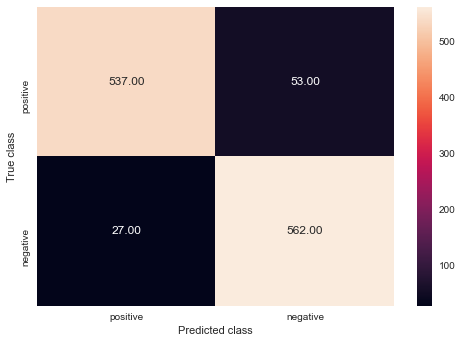

In [325]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [326]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.9321141426665296 f1_score on  unseen test data


In [327]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       590
           1       0.91      0.95      0.93       589

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



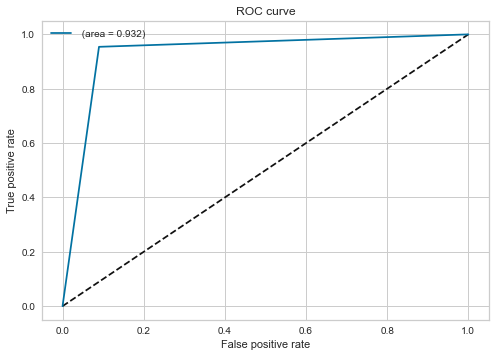

In [328]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_tfidf,y_pred)

In [329]:
validation_score_logistic=log_reg.best_score_
test_score_logistic=score
train_score_logistic=f1_score(ytrain_tfidf,log_reg.predict(xtrain_tfidf),average='weighted')

### Multinomial Naive Bayes

In [330]:
###Naive Bayes
clf2 = MultinomialNB()
param2={'alpha':[0.001,0.01,0.005,0.05,0.1,1,10,100]}
clf_MNB=tuning(clf2,param2,xtrain_tfidf,ytrain_tfidf)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.6s finished


In [331]:
result=pd.DataFrame(clf_MNB.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014262,0.001671,0.004488,0.000920,0.001,{'alpha': 0.001},0.926311,0.925463,0.922479,0.924442,0.914916,0.927117,0.915740,0.927227,0.922409,0.917687,0.922379,0.004438,1
1,0.016607,0.001379,0.004687,0.001002,0.01,{'alpha': 0.01},0.925330,0.923566,0.922445,0.923490,0.913904,0.923296,0.911912,0.927215,0.918589,0.912910,0.920266,0.005257,3
2,0.017354,0.001954,0.004588,0.000662,0.005,{'alpha': 0.005},0.923455,0.924515,0.922445,0.924442,0.914879,0.925208,0.914784,0.926264,0.921455,0.912910,0.921036,0.004685,2
3,0.015658,0.001787,0.004289,0.000639,0.05,{'alpha': 0.05},0.926220,0.916878,0.919580,0.920635,0.909118,0.920446,0.909950,0.925285,0.915721,0.908145,0.917198,0.006139,4
4,0.019250,0.004571,0.004787,0.001075,0.1,{'alpha': 0.1},0.922419,0.912115,0.912883,0.919683,0.910030,0.919470,0.908030,0.923363,0.912827,0.903352,0.914417,0.006245,5
5,0.015457,0.001798,0.004489,0.000804,1,{'alpha': 1},0.905217,0.895739,0.897528,0.912968,0.896530,0.904071,0.904071,0.912805,0.902201,0.894637,0.902577,0.006293,6
6,0.013664,0.001672,0.003890,0.000699,10,{'alpha': 10},0.907113,0.891819,0.894563,0.910053,0.881098,0.889583,0.895439,0.903222,0.888729,0.886865,0.894848,0.008828,7
7,0.012865,0.001041,0.003790,0.000746,100,{'alpha': 100},0.892784,0.883222,0.879282,0.891801,0.870514,0.869322,0.877142,0.896472,0.885933,0.877049,0.882352,0.008864,8


In [332]:
print("Optimal score for Multinomial Naive Bayes: %0.3f" % clf_MNB.best_score_)
print("Optimal parameter for Multinomial Naive Bayes: " + str(clf_MNB.best_params_))

Optimal score for Multinomial Naive Bayes: 0.922
Optimal parameter for Multinomial Naive Bayes: {'alpha': 0.001}


In [333]:
#evaluate model performance
y_pred=clf_MNB.predict(xtest_tfidf) # predict on unseen data
matrix,report,score=metrics(ytest_tfidf,y_pred)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

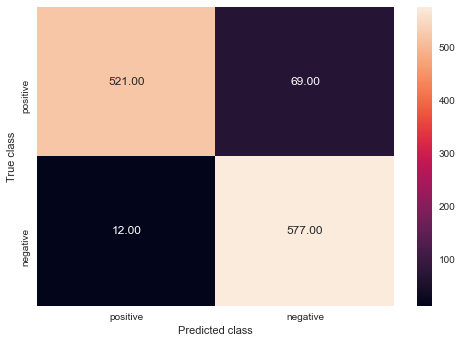

In [334]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [335]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.9311395897136109 f1_score on  unseen test data


In [336]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       590
           1       0.89      0.98      0.93       589

    accuracy                           0.93      1179
   macro avg       0.94      0.93      0.93      1179
weighted avg       0.94      0.93      0.93      1179



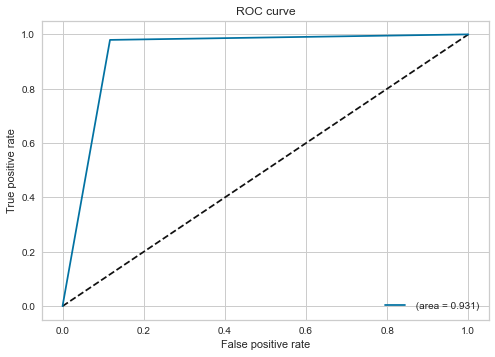

In [337]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_tfidf,y_pred)

In [338]:
validation_score_MNB=clf_MNB.best_score_
test_score_MNB=score
train_MNB_score=f1_score(ytrain_tfidf,clf_MNB.predict(xtrain_tfidf),average='weighted')

### SVM

In [339]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

svd =TruncatedSVD(n_components=120)# since it takes lot of time for SVM model to fit and predict for text data, we used TruncatedSVD for dimensionallity reduction
svd.fit(xtrain_tfidf)
xtrain_svd = svd.transform(xtrain_tfidf)
xtest_svd = svd.transform(xtest_tfidf)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

clf3 = SVC(probability=True) 
param3={'C':[0.001,0.01,0.1,1,10,100]}
clf_svm=tuning(clf3,param3,xtrain_svd_scl,ytrain_tfidf)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 30.4min finished


In [340]:
result=pd.DataFrame(clf_svm.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,390.792756,6.154291,5.133282,0.733358,0.001,{'C': 0.001},0.332810,0.332810,0.693162,0.701580,0.739024,0.333333,0.333333,0.333333,0.333333,0.333333,0.446605,0.173598,6
1,340.162336,10.195768,4.303442,0.615574,0.01,{'C': 0.01},0.781377,0.756702,0.749188,0.766016,0.789297,0.747800,0.742807,0.741926,0.757486,0.766085,0.759869,0.015144,5
2,231.005961,8.090465,2.967267,0.362674,0.1,{'C': 0.1},0.881960,0.879266,0.880182,0.874574,0.885782,0.875171,0.884742,0.866918,0.867717,0.875171,0.877148,0.006141,4
3,160.288780,3.474046,2.002805,0.257762,1,{'C': 1},0.915068,0.915125,0.911331,0.928348,0.913227,0.901702,0.914022,0.917879,0.907402,0.913096,0.913720,0.006526,3
4,154.176686,3.465006,1.641913,0.172869,10,{'C': 10},0.924541,0.925514,0.932059,0.936831,0.935881,0.925423,0.930125,0.935841,0.924468,0.940533,0.931122,0.005652,1
5,131.253681,15.017983,1.240512,0.168950,100,{'C': 100},0.923576,0.920741,0.932998,0.930211,0.929283,0.932997,0.925360,0.934885,0.926394,0.933939,0.929038,0.004585,2


In [341]:
print("Optimal score for SVM: %0.3f" % clf_svm.best_score_)
print("Optimal parameter for SVM: " + str(clf_svm.best_params_))

Optimal score for SVM: 0.931
Optimal parameter for SVM: {'C': 10}


In [342]:
#evaluate model performance
y_pred=clf_svm.predict(xtest_svd_scl) # predict on unseen data
matrix,report,score=metrics(ytest_tfidf,y_pred)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

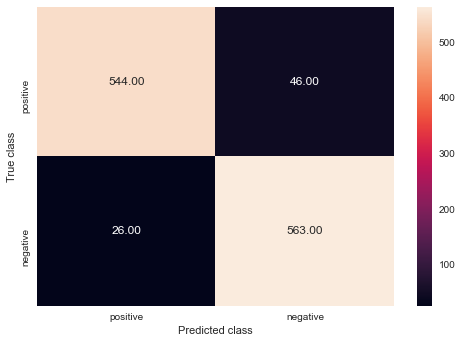

In [343]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [344]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.938914598824662 f1_score on  unseen test data


In [345]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       590
           1       0.92      0.96      0.94       589

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



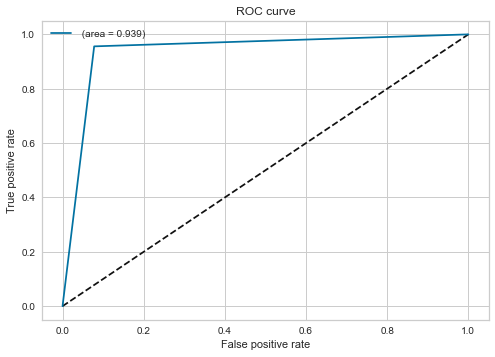

In [346]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_tfidf,y_pred)

In [347]:
validation_score_svm=clf_svm.best_score_
test_score_svm=score
train_score_svm=f1_score(ytrain_tfidf,clf_svm.predict(xtrain_svd_scl),average='weighted')

### Naive Bayes(Bernouli)

In [348]:
###Naive Bayes
clf4 = BernoulliNB()
param4={'alpha':[0.001,0.01,0.005,0.05,0.1,1,10,100]}
clf_BNB=tuning(clf4,param4,xtrain_tfidf,ytrain_tfidf)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished


In [349]:
result=pd.DataFrame(clf_BNB.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016906,0.003328,0.005505,0.001019,0.001,{'alpha': 0.001},0.915723,0.928187,0.920416,0.919599,0.916648,0.911799,0.909877,0.923331,0.916638,0.915615,0.917783,0.005090,1
1,0.013759,0.001882,0.004791,0.000885,0.01,{'alpha': 0.01},0.916637,0.926237,0.918475,0.914819,0.910891,0.910838,0.905064,0.921384,0.909926,0.914656,0.914893,0.005835,3
2,0.014474,0.002315,0.005712,0.000992,0.005,{'alpha': 0.005},0.916659,0.927206,0.920394,0.915776,0.913772,0.911799,0.908915,0.922340,0.913764,0.915615,0.916624,0.005095,2
3,0.013264,0.001185,0.004527,0.000473,0.05,{'alpha': 0.05},0.907993,0.917638,0.910784,0.911924,0.907951,0.906991,0.900240,0.918513,0.904157,0.905035,0.909123,0.005466,4
4,0.014918,0.002466,0.005212,0.001161,0.1,{'alpha': 0.1},0.905104,0.910929,0.906927,0.910965,0.903160,0.905035,0.898307,0.913719,0.899337,0.903075,0.905656,0.004797,5
5,0.013862,0.001693,0.004492,0.000919,1,{'alpha': 1},0.881728,0.881917,0.890401,0.898429,0.884683,0.883698,0.885560,0.899241,0.888611,0.879790,0.887406,0.006457,6
6,0.014162,0.002176,0.004787,0.000870,10,{'alpha': 10},0.850230,0.861037,0.853797,0.869044,0.847105,0.856828,0.852985,0.862076,0.855830,0.844047,0.855298,0.007053,7
7,0.015157,0.001998,0.004886,0.000813,100,{'alpha': 100},0.723081,0.725962,0.740355,0.729251,0.749580,0.740147,0.740651,0.748731,0.720979,0.707290,0.732603,0.012853,8


In [350]:
print("Optimal score for Bernouli: %0.3f" % clf_BNB.best_score_)
print("Optimal parameter for Bernouli: " + str(clf_BNB.best_params_))

Optimal score for Bernouli: 0.918
Optimal parameter for Bernouli: {'alpha': 0.001}


In [351]:
#evaluate model performance
y_pred=clf_BNB.predict(xtest_tfidf) # predict on unseen data
matrix,report,score=metrics(ytest_tfidf,y_pred)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

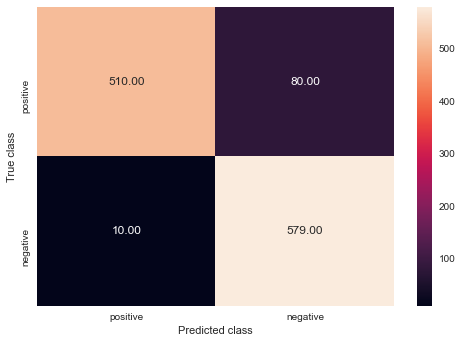

In [352]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [353]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.9233979649055986 f1_score on  unseen test data


In [354]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       590
           1       0.88      0.98      0.93       589

    accuracy                           0.92      1179
   macro avg       0.93      0.92      0.92      1179
weighted avg       0.93      0.92      0.92      1179



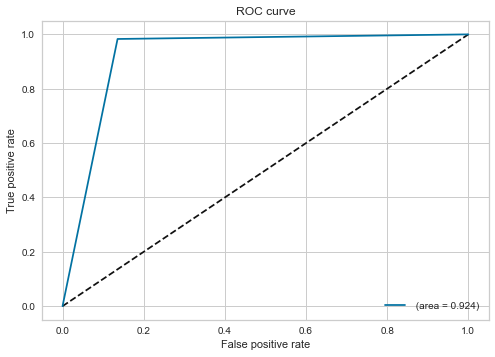

In [355]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_tfidf,y_pred)

In [356]:
validation_score_BNB=clf_BNB.best_score_
test_score_BNB=score
train_score_BNB=f1_score(ytrain_tfidf,clf_BNB.predict(xtrain_tfidf),average='weighted')

### RidgeClassifier

In [357]:
clf5=RidgeClassifier()
param5={'alpha':[0.001,0.01,0.005,0.05,0.1,1,10,100]}
clf_RCF=tuning(clf5,param5,xtrain_tfidf,ytrain_tfidf)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.0s finished


In [358]:
result=pd.DataFrame(clf_RCF.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.370008,0.020209,0.007081,0.003690,0.001,{'alpha': 0.001},0.873601,0.873644,0.880687,0.869866,0.862949,0.862561,0.864632,0.864048,0.856950,0.860819,0.866976,0.006877,8
1,0.216532,0.024056,0.004887,0.000698,0.01,{'alpha': 0.01},0.891015,0.883434,0.902710,0.887301,0.879482,0.879177,0.873512,0.881450,0.883101,0.881238,0.884242,0.007606,6
2,0.252657,0.018577,0.006283,0.002715,0.005,{'alpha': 0.005},0.882292,0.875667,0.895052,0.880557,0.879444,0.871379,0.870546,0.874758,0.869617,0.871566,0.877088,0.007325,7
3,0.131593,0.017052,0.004987,0.000773,0.05,{'alpha': 0.05},0.910189,0.898865,0.921674,0.904526,0.896798,0.904185,0.898549,0.905433,0.910976,0.895798,0.904699,0.007563,4
4,0.112907,0.010234,0.005536,0.001999,0.1,{'alpha': 0.1},0.917816,0.903671,0.929241,0.912123,0.906356,0.913807,0.903352,0.910216,0.914839,0.907230,0.911865,0.007377,3
5,0.067671,0.003485,0.005286,0.000457,1,{'alpha': 1},0.936806,0.916956,0.931120,0.926445,0.921674,0.922469,0.911107,0.922542,0.928219,0.917789,0.923513,0.007074,1
6,0.042140,0.003055,0.004488,0.000669,10,{'alpha': 10},0.929246,0.913260,0.920772,0.921763,0.903821,0.912145,0.913107,0.918845,0.917854,0.920653,0.917147,0.006561,2
7,0.029621,0.003249,0.004088,0.000829,100,{'alpha': 100},0.907634,0.892554,0.891612,0.901974,0.891603,0.886752,0.903732,0.906603,0.889579,0.902792,0.897484,0.007380,5


In [359]:
print("Optimal score for Ridge Classifier: %0.3f" % clf_RCF.best_score_)
print("Optimal parameter for Ridge Classifier: " + str(clf_RCF.best_params_))

Optimal score for Ridge Classifier: 0.924
Optimal parameter for Ridge Classifier: {'alpha': 1}


In [360]:
#evaluate model performance
y_pred=clf_RCF.predict(xtest_tfidf) # predict on unseen data
matrix,report,score=metrics(ytest_tfidf,y_pred)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

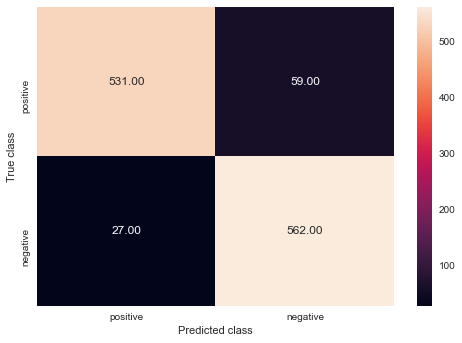

In [361]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [362]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.9270047360567157 f1_score on  unseen test data


In [363]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       590
           1       0.90      0.95      0.93       589

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



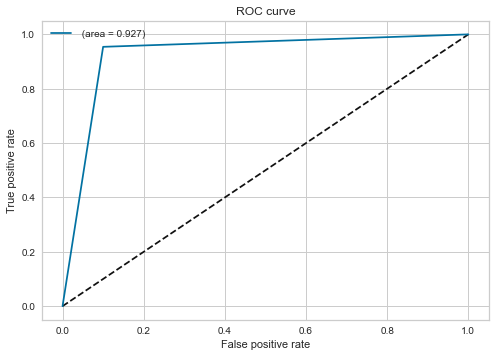

In [364]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_tfidf,y_pred)

In [365]:
validation_score_rcf=clf_svm.best_score_
test_score_rcf=score
train_score_rcf=f1_score(ytrain_tfidf,clf_RCF.predict(xtrain_tfidf),average='weighted')

## Model for CountVectorizer

### Logistic Regression

In [306]:
clf1_ctv=LogisticRegression(C=10)
param1={'C':[0.001,0.01,0.1,1,10,100]}
log_reg_ctv=tuning(clf1_ctv,param1,xtrain_ctv,ytrain_ctv)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.4s finished
C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [307]:
result=pd.DataFrame(log_reg_ctv.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.475497,0.038065,0.006482,0.001957,0.001,{'C': 0.001},0.821657,0.817369,0.824122,0.821094,0.820895,0.799429,0.812822,0.820844,0.802466,0.800530,0.814123,0.009193,6
1,1.165724,0.148795,0.008017,0.003549,0.01,{'C': 0.01},0.855759,0.840950,0.853143,0.845385,0.852339,0.824844,0.845317,0.855910,0.837937,0.837324,0.844891,0.009416,5
2,1.903319,0.247786,0.006690,0.000888,0.1,{'C': 0.1},0.878607,0.874657,0.876729,0.868289,0.876867,0.858524,0.869957,0.878588,0.870637,0.865346,0.871820,0.006209,4
3,3.780075,0.725678,0.012261,0.011479,1,{'C': 1},0.887476,0.880574,0.886578,0.871373,0.886554,0.873093,0.876790,0.878803,0.881602,0.875148,0.879799,0.005496,2
4,8.352821,0.601784,0.010435,0.006719,10,{'C': 10},0.883668,0.877781,0.885666,0.870522,0.887556,0.878775,0.872966,0.881709,0.883551,0.874260,0.879645,0.005437,3
5,8.057651,1.694604,0.006390,0.001121,100,{'C': 100},0.886542,0.877814,0.881886,0.873394,0.890380,0.879736,0.875793,0.883649,0.883577,0.876128,0.880890,0.005034,1


In [308]:
print("Optimal score for Logistic Regression: %0.3f" % log_reg_ctv.best_score_)
print("Optimal parameter for Logistic Regression: " + str(log_reg_ctv.best_params_))

Optimal score for Logistic Regression: 0.881
Optimal parameter for Logistic Regression: {'C': 100}


In [309]:
#evaluate model performance
y_pred_ctv=log_reg_ctv.predict(xtest_ctv) # predict on unseen data
matrix,report,score=metrics(ytest_ctv,y_pred_ctv)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

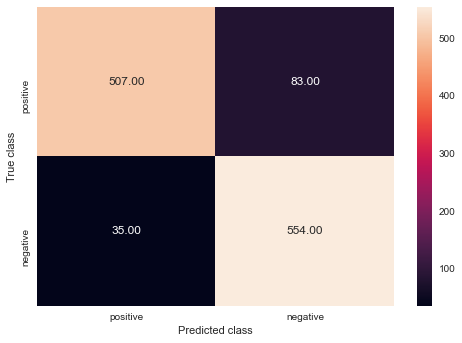

In [310]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [311]:
print("We got {} accuracy on  unseen test data".format(score))

We got 0.8997524887836358 accuracy on  unseen test data


In [312]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       590
           1       0.87      0.94      0.90       589

    accuracy                           0.90      1179
   macro avg       0.90      0.90      0.90      1179
weighted avg       0.90      0.90      0.90      1179



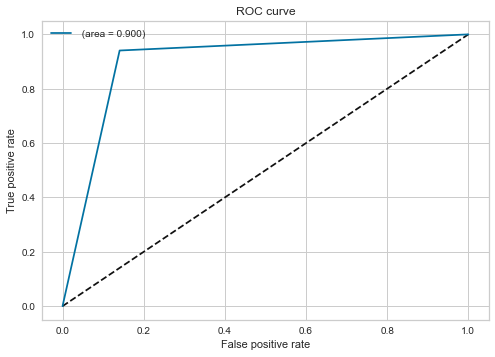

In [313]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_ctv,y_pred_ctv)

In [314]:
validation_score_logistic_ctv=log_reg_ctv.best_score_
test_score_logistic_ctv=score
train_score_logistic_ctv=f1_score(ytrain_ctv,log_reg_ctv.predict(xtrain_ctv),average='weighted')

### Naive Bayes(Multinomial)

In [315]:
###Naive Bayes
clf2_ctv = MultinomialNB()
param2_ctv={'alpha':[0.001,0.01,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.00000001,0.0000000001]}
clf_MNB_ctv=tuning(clf2_ctv,param2_ctv,xtrain_ctv,ytrain_ctv)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.1s finished


In [316]:
result=pd.DataFrame(clf_MNB_ctv.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038098,0.002175,0.008677,0.001414,0.001,{'alpha': 0.001},0.814859,0.811222,0.545987,0.529573,0.534733,0.817730,0.801701,0.829274,0.806234,0.792602,0.728391,0.125840,8
1,0.035804,0.003291,0.008130,0.001139,0.01,{'alpha': 0.01},0.759421,0.749302,0.508910,0.490544,0.499327,0.754936,0.758019,0.788547,0.753396,0.728537,0.679094,0.118380,9
2,0.035903,0.003758,0.008777,0.000870,0.0001,{'alpha': 0.0001},0.849462,0.843018,0.571128,0.557666,0.559826,0.844296,0.831578,0.858440,0.845298,0.818817,0.757953,0.128137,7
3,0.033509,0.002491,0.008332,0.001334,1e-05,{'alpha': 1e-05},0.869355,0.866044,0.580565,0.565030,0.576108,0.864632,0.850855,0.872539,0.867361,0.848020,0.776051,0.132588,6
4,0.034906,0.003759,0.007784,0.001094,1e-06,{'alpha': 1e-06},0.879174,0.877877,0.582648,0.576152,0.587752,0.869663,0.857115,0.879450,0.877398,0.860150,0.784738,0.132830,5
5,0.036852,0.004658,0.008079,0.001133,1e-07,{'alpha': 1e-07},0.888919,0.878020,0.587936,0.578337,0.594076,0.876546,0.860198,0.889153,0.884279,0.871930,0.790939,0.133937,4
6,0.033952,0.004814,0.007880,0.000828,1e-08,{'alpha': 1e-08},0.891948,0.886691,0.589026,0.579302,0.598409,0.884342,0.862364,0.891125,0.885391,0.870325,0.793892,0.134535,2
7,0.034926,0.003524,0.008079,0.001041,1e-08,{'alpha': 1e-08},0.891948,0.886691,0.589026,0.579302,0.598409,0.884342,0.862364,0.891125,0.885391,0.870325,0.793892,0.134535,2
8,0.038126,0.004260,0.008278,0.001342,1e-10,{'alpha': 1e-10},0.894010,0.887736,0.589666,0.584183,0.602037,0.897786,0.866479,0.890341,0.891277,0.870521,0.797404,0.134879,1


In [317]:
print("Optimal score for Multinomial Bayes: %0.3f" % clf_MNB_ctv.best_score_)
print("Optimal parameter for Multinomial Bayes: " + str(clf_MNB_ctv.best_params_))

Optimal score for Multinomial Bayes: 0.797
Optimal parameter for Multinomial Bayes: {'alpha': 1e-10}


In [318]:
#evaluate model performance
y_pred_ctv=clf_MNB_ctv.predict(xtest_ctv) # predict on unseen data
matrix,report,score=metrics(ytest_ctv,y_pred_ctv)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

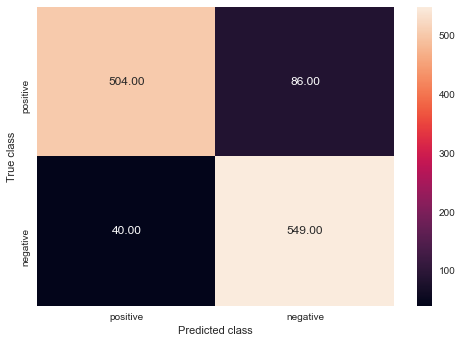

In [319]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [320]:
print("We got {} accuracy on  unseen test data".format(score))

We got 0.89297039143619 accuracy on  unseen test data


In [321]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       590
           1       0.86      0.93      0.90       589

    accuracy                           0.89      1179
   macro avg       0.90      0.89      0.89      1179
weighted avg       0.90      0.89      0.89      1179



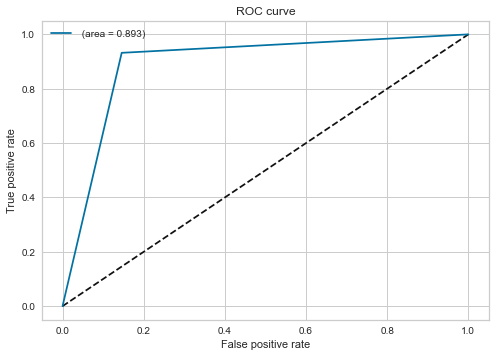

In [322]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_ctv,y_pred_ctv)

In [323]:
validation_score_MNB_ctv=clf_MNB_ctv.best_score_
test_score_MNB_ctv=score
train_score_MNB_ctv=f1_score(ytrain_ctv,clf_MNB_ctv.predict(xtrain_ctv),average='weighted')

### SVM

In [358]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

svd =TruncatedSVD(n_components=120)
svd.fit(xtrain_ctv)
xtrain_svd = svd.transform(xtrain_ctv)
xtest_svd = svd.transform(xtest_ctv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

clf3 = SVC(C=1.0, probability=True) 
param3={'C':[0.001,0.01,0.1,1,10,100]}
clf_svm_ctv=tuning(clf3,param3,xtrain_svd_scl,ytrain_ctv)
# since we need probabilities
#clf.fit(xtrain_svd_scl, ytrain)
#y_pred = clf.predict(xvalid_svd_scl)
#print(classification_report(yvalid,y_pred))
#print(confusion_matrix(yvalid,y_pred))

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 26.2min finished


In [359]:
result=pd.DataFrame(clf_svm_ctv.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,390.786295,12.428857,5.170557,0.758406,0.001,{'C': 0.001},0.752701,0.761742,0.763853,0.752963,0.754358,0.734476,0.769213,0.769564,0.756863,0.727142,0.754288,0.013204,6
1,238.546412,13.949703,2.849502,0.388285,0.01,{'C': 0.01},0.812371,0.812415,0.810555,0.789796,0.804899,0.784906,0.823528,0.805654,0.803729,0.784899,0.803275,0.012226,5
2,173.834312,8.607046,2.317377,0.365916,0.1,{'C': 0.1},0.861185,0.873606,0.854789,0.859351,0.871699,0.836523,0.856378,0.865930,0.859262,0.848841,0.858757,0.010296,4
3,144.892148,6.913927,1.809034,0.236678,1,{'C': 1},0.895163,0.899098,0.884942,0.886765,0.896238,0.866801,0.879841,0.893316,0.880867,0.876295,0.885933,0.009709,1
4,137.938335,7.922368,1.514567,0.205956,10,{'C': 10},0.894334,0.893482,0.884058,0.883969,0.893444,0.869733,0.886631,0.887719,0.879148,0.876390,0.884891,0.007640,2
5,126.260292,9.662955,1.182777,0.180873,100,{'C': 100},0.885905,0.889706,0.870876,0.881228,0.876525,0.882010,0.871632,0.887736,0.878278,0.876412,0.880031,0.006129,3


In [360]:
print("Optimal score for SVM: %0.3f" % clf_svm_ctv.best_score_)
print("Optimal parameter for SVM: " + str(clf_svm_ctv.best_params_))

Optimal score for SVM: 0.886
Optimal parameter for SVM: {'C': 1}


In [361]:
#evaluate model performance
y_pred_ctv=clf_svm_ctv.predict(xtest_svd_scl) # predict on unseen data
matrix,report,score=metrics(ytest_ctv,y_pred_ctv)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

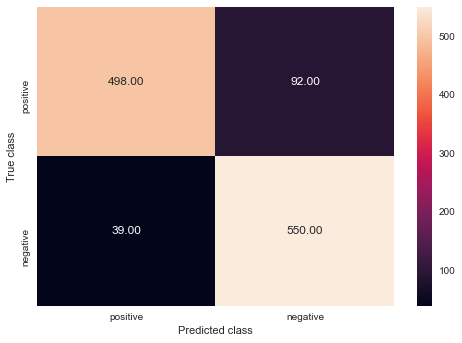

In [362]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [363]:
print("We got {} f1_score on  unseen test data".format(score))

We got 0.8886681622577804 f1_score on  unseen test data


In [364]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       590
           1       0.86      0.93      0.89       589

    accuracy                           0.89      1179
   macro avg       0.89      0.89      0.89      1179
weighted avg       0.89      0.89      0.89      1179



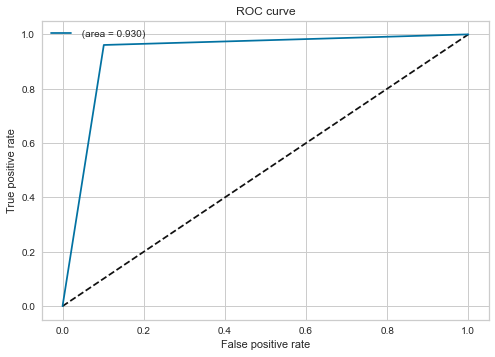

In [365]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_ctv,y_pred)

In [366]:
validation_score_svm_ctv=clf_svm_ctv.best_score_
test_score_svm_ctv=score
train_score_svm_ctv=f1_score(ytrain_ctv,clf_svm_ctv.predict(xtrain_svd_scl),average='weighted')

### Naive Bayes(Bernouli)

In [325]:
###Naive Bayes
clf4_ctv = BernoulliNB()
param4_ctv={'alpha':[0.001,0.01,0.1,1,0.0001,0.00001,0.000001,0.0000001]}
clf_BNB_ctv=tuning(clf4_ctv,param4_ctv,xtrain_ctv,ytrain_ctv)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.9s finished


In [326]:
result=pd.DataFrame(clf_BNB_ctv.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046726,0.003170,0.031918,0.003132,0.001,{'alpha': 0.001},0.866116,0.866681,0.865568,0.868610,0.881894,0.863313,0.856527,0.870250,0.876072,0.848942,0.866397,0.008752,5
1,0.047872,0.004415,0.032115,0.003618,0.01,{'alpha': 0.01},0.843044,0.837357,0.855104,0.841249,0.854031,0.851907,0.836072,0.851140,0.846976,0.839363,0.845624,0.006759,6
2,0.038691,0.004007,0.027029,0.003552,0.1,{'alpha': 0.1},0.781762,0.789060,0.807030,0.798502,0.804802,0.795324,0.785601,0.791562,0.779167,0.796827,0.792964,0.008812,7
3,0.040041,0.004749,0.027061,0.003944,1,{'alpha': 1},0.676536,0.663339,0.699766,0.689327,0.689327,0.676904,0.681800,0.693541,0.652359,0.655714,0.677861,0.015357,8
4,0.042516,0.003557,0.028101,0.003474,0.0001,{'alpha': 0.0001},0.886743,0.873846,0.871678,0.875762,0.896530,0.878329,0.866786,0.879219,0.884107,0.861077,0.877408,0.009641,4
5,0.040194,0.004145,0.027092,0.003418,1e-05,{'alpha': 1e-05},0.893613,0.881603,0.878625,0.885547,0.903362,0.889970,0.867049,0.895690,0.890964,0.868098,0.885452,0.011155,3
6,0.040267,0.002839,0.025113,0.002024,1e-06,{'alpha': 1e-06},0.898597,0.892215,0.889224,0.888511,0.902527,0.900592,0.873994,0.904400,0.896850,0.878803,0.892571,0.009594,2
7,0.039919,0.005229,0.025511,0.002734,1e-07,{'alpha': 1e-07},0.902562,0.900906,0.897060,0.889603,0.902693,0.907357,0.872190,0.907357,0.898920,0.883671,0.896232,0.010672,1


In [327]:
print("Optimal score for Bernouli Naive Bayes: %0.3f" % clf_BNB_ctv.best_score_)
print("Optimal parameter for Bernouli Naive Bayes: " + str(clf_BNB_ctv.best_params_))

Optimal score for Bernouli Naive Bayes: 0.896
Optimal parameter for Bernouli Naive Bayes: {'alpha': 1e-07}


In [328]:
#evaluate model performance
y_pred_ctv=clf_BNB_ctv.predict(xtest_ctv) # predict on unseen data
matrix,report,score=metrics(ytest_ctv,y_pred_ctv)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

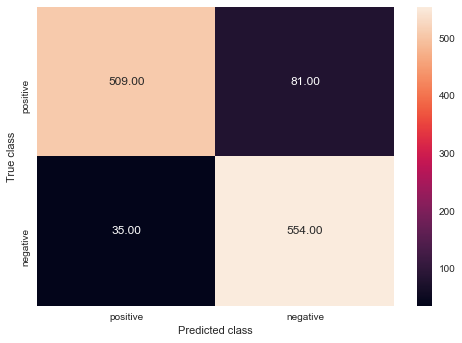

In [329]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [330]:
print("We got {} accuracy on  unseen test data".format(score))

We got 0.9014648048142703 accuracy on  unseen test data


In [331]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       590
           1       0.87      0.94      0.91       589

    accuracy                           0.90      1179
   macro avg       0.90      0.90      0.90      1179
weighted avg       0.90      0.90      0.90      1179



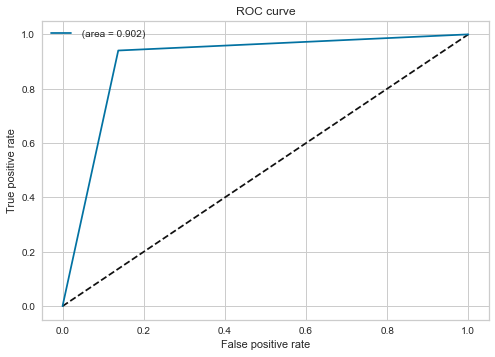

In [332]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_ctv,y_pred_ctv)

In [333]:
validation_score_BNB_ctv=clf_BNB_ctv.best_score_
test_score_BNB_ctv=score
train_score_BNB_ctv=f1_score(ytrain_ctv,clf_BNB_ctv.predict(xtrain_ctv),average='weighted')

### RidgeClassifier

In [334]:
clf5_ctv=RidgeClassifier()
param5_ctv={'alpha':[0.001,0.01,0.005,0.05,0.1,1,10,100]}
clf_RCF_ctv=tuning(clf5_ctv,param5_ctv,xtrain_ctv,ytrain_ctv)

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   42.1s finished


In [335]:
result=pd.DataFrame(clf_RCF_ctv.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.157724,1.642963,0.007370,0.000923,0.001,{'alpha': 0.001},0.832683,0.838493,0.849893,0.832796,0.843607,0.847097,0.830888,0.851455,0.836477,0.842797,0.840619,0.007068,8
1,6.671345,1.100296,0.008284,0.003266,0.01,{'alpha': 0.01},0.834670,0.836654,0.850868,0.834707,0.844593,0.850984,0.831879,0.851400,0.840303,0.843837,0.841989,0.007061,6
2,7.679728,0.782774,0.009885,0.005477,0.005,{'alpha': 0.005},0.833677,0.837573,0.849893,0.833788,0.843607,0.849008,0.830888,0.851400,0.839310,0.842797,0.841194,0.006954,7
3,4.336447,0.602488,0.007190,0.001740,0.05,{'alpha': 0.05},0.838705,0.839693,0.855780,0.841765,0.844778,0.849261,0.837610,0.855418,0.843342,0.849861,0.845621,0.006311,5
4,3.314617,0.723407,0.009991,0.006294,0.1,{'alpha': 0.1},0.846593,0.848438,0.858691,0.846682,0.846855,0.852325,0.843408,0.852590,0.846304,0.853799,0.849568,0.004385,4
5,1.405518,0.414594,0.014262,0.015361,1,{'alpha': 1},0.860296,0.861270,0.868289,0.855735,0.857541,0.854230,0.851228,0.862364,0.857220,0.852109,0.858028,0.004915,2
6,0.527996,0.090747,0.011595,0.009856,10,{'alpha': 10},0.868031,0.864928,0.867207,0.858467,0.864167,0.862100,0.850362,0.865150,0.858094,0.851944,0.861045,0.005847,1
7,0.227585,0.041594,0.007490,0.001020,100,{'alpha': 100},0.860744,0.858777,0.861972,0.847722,0.861046,0.837679,0.853077,0.860925,0.843066,0.850304,0.853531,0.008168,3


In [336]:
print("Optimal score for Ridge Classifier: %0.3f" % clf_RCF_ctv.best_score_)
print("Optimal parameter for  Ridge Classifier: " + str(clf_RCF_ctv.best_params_))

Optimal score for Ridge Classifier: 0.861
Optimal parameter for  Ridge Classifier: {'alpha': 10}


In [337]:
#evaluate model performance
y_pred_ctv=clf_RCF_ctv.predict(xtest_ctv) # predict on unseen data
matrix,report,score=metrics(ytest_ctv,y_pred_ctv)

confusion matrix is given below:


Text(0.5, 29.5, 'Predicted class')

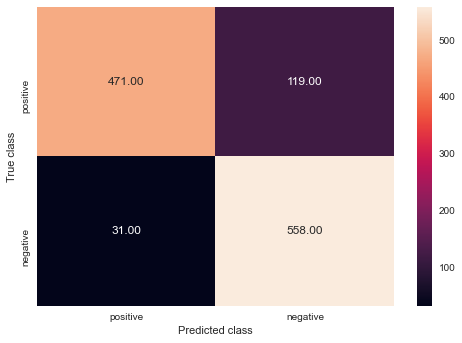

In [338]:
#confusion matrix of Random forest Classifier
print("confusion matrix is given below:")
sns.heatmap(matrix, annot=True, fmt='.2f',xticklabels = ["positive","negative"] , yticklabels = ["positive","negative"])
plt.ylabel('True class')
plt.xlabel('Predicted class')

In [339]:
print("We got {} accuracy on  unseen test data".format(score))

We got 0.8720689687007838 accuracy on  unseen test data


In [340]:
print("classification report is given below:")
print(report)

classification report is given below:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       590
           1       0.82      0.95      0.88       589

    accuracy                           0.87      1179
   macro avg       0.88      0.87      0.87      1179
weighted avg       0.88      0.87      0.87      1179



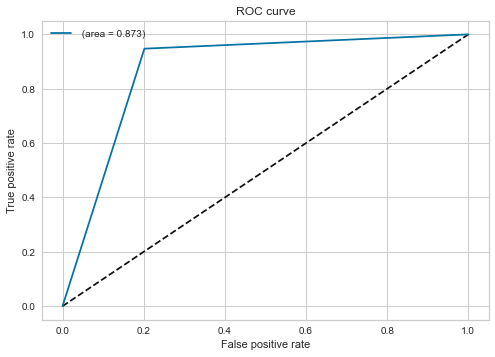

In [341]:
#ROC_AUC_CURVE IS GIVEN BELOW
curve(ytest_ctv,y_pred_ctv)

In [342]:
validation_score_RCF_ctv=clf_RCF_ctv.best_score_
test_score_RCF_ctv=score
train_score_RCF_ctv=f1_score(ytrain_ctv,clf_RCF_ctv.predict(xtrain_ctv),average='weighted')

## CONCLUSION

In [366]:
validation_score=[validation_score_logistic,validation_score_MNB,validation_score_BNB,validation_score_rcf,validation_score_svm]
test_score=[test_score_logistic,test_score_MNB,test_score_BNB,test_score_rcf,test_score_svm]
train_score=[train_score_logistic,train_score_BNB,train_MNB_score,train_score_rcf,train_score_svm]
model=['Logistic Regression','Multinomial_NB','Bernouli_NB','Ridge Classifier','Support Vector Machine']

In [367]:
#create dataframe for accuracy of model with TfidfVectorizer
tfidf_df=pd.DataFrame({'model':model,'train_accuracy':train_score,'validation_accuracy':validation_score,'test_accuracy':test_score})

In [368]:
tfidf_df

,model,train_accuracy,validation_accuracy,test_accuracy
0,Logistic Regression,0.974722,0.929476,0.932114
1,Multinomial_NB,0.929769,0.922379,0.931140
2,Bernouli_NB,0.939996,0.917783,0.923398
3,Ridge Classifier,0.962259,0.931122,0.927005
4,Support Vector Machine,0.987553,0.931122,0.938915


In [353]:
tfidf_df

,model,train_accuracy,validation_accuracy,test_accuracy
0,Logistic Regression,0.974062,0.927037,0.932103
1,Multinomial_NB,0.929094,0.922277,0.931984
2,Bernouli_NB,0.939807,0.917209,0.926802
3,Ridge Classifier,0.962736,0.926400,0.929534
4,Support Vector Machine,0.986610,0.926400,0.931284


In [367]:
validation_score=[validation_score_logistic_ctv,validation_score_MNB_ctv,validation_score_BNB_ctv,validation_score_RCF_ctv,validation_score_svm_ctv]
test_score=[test_score_logistic_ctv,test_score_MNB_ctv,test_score_BNB_ctv,test_score_RCF_ctv,test_score_svm_ctv]
train_score=[train_score_logistic_ctv,train_score_BNB_ctv,train_score_MNB_ctv,train_score_RCF_ctv,train_score_svm_ctv]
model=['Logistic Regression','Multinomial_NB','Bernouli_NB','Ridge Classifier','Support Vector Machine']

In [368]:
#Create dataframe for accuracy of model with Count Vectorizer
CountVector_df=pd.DataFrame({'model':model,'train_accuracy':train_score,'validation_accuracy':validation_score,'test_accuracy':test_score})

In [369]:
CountVector_df

,model,train_accuracy,validation_accuracy,test_accuracy
0,Logistic Regression,0.999246,0.880890,0.899752
1,Multinomial_NB,0.998397,0.797404,0.892970
2,Bernouli_NB,0.995662,0.896232,0.901465
3,Ridge Classifier,0.993116,0.861045,0.872069
4,Support Vector Machine,0.912988,0.885933,0.888668


     We can clearly see that models with TfidfVectorizer works well wthan model with CountVectorizer.Let's find model                performance of various model with one shot.

## MODEL

In [381]:
# IMPORTING MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
# IMPORTING SCORING PARAMETERS
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score,matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate,cross_val_score

In [382]:
# vOTING cLASSIFIRE
clf1 = LogisticRegression(C = 10)
clf2 = SGDClassifier(loss='log',max_iter=1, tol=1e-1)
eclf1 = VotingClassifier(estimators=[('lr', LogisticRegression(C = 10)),('RCF',RidgeClassifier(alpha=1))],voting ='hard')

In [383]:
clf = {
"MultinomialNB": MultinomialNB(alpha = 0.001),
"LogisticRegression": LogisticRegression(C = 10),
"BernoulliNB": BernoulliNB(alpha=0.001),
"RidgeClassifier":RidgeClassifier(alpha=1),
"PassiveAggressiveClassifier":PassiveAggressiveClassifier(C=0.1),
"Perceptron":Perceptron(tol=1e-3,random_state=0),
"LinearSVC":LinearSVC(class_weight='balanced',C=1.1),  
"randomForest":RandomForestClassifier() ,
"voting":eclf1,
"SGD":clf2    
}

In [384]:
np.random.seed(42)

In [385]:

    result = []
    m = []
    for name, model in clf.items():
        scoring = {
        'accuracy': make_scorer(accuracy_score),
        'sensitivity/recall': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0),
        'precision': make_scorer(precision_score),
        'f1':make_scorer(f1_score),
        'roc_auc':make_scorer(roc_auc_score),
        'Mcc':make_scorer(matthews_corrcoef)
        }
        cv_results = cross_validate(model,xtrain_tfidf,ytrain_tfidf, cv=10, scoring=scoring)
    
        print("----------------------------------")
        print(name)
        print("----------------------------------")
        cr = pd.DataFrame(cv_results)
        cr = cr.append({'Model': name}, ignore_index=True)
        testre = cr.drop(['fit_time', 'score_time'], axis=1)
        print(testre.mean(axis = 0))
        m.append(name)
    
        result.append(testre.mean(axis = 0))
    result = pd.DataFrame(result)
    result.insert(0, "Model",m, True)
    result

----------------------------------
MultinomialNB
----------------------------------
test_accuracy              0.920131
test_sensitivity/recall    0.971337
test_specificity           0.868917
test_precision             0.881156
test_f1                    0.924032
test_roc_auc               0.920127
test_Mcc                   0.844744
dtype: float64


C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



----------------------------------
LogisticRegression
----------------------------------
test_accuracy              0.926732
test_sensitivity/recall    0.956252
test_specificity           0.897207
test_precision             0.902970
test_f1                    0.928823
test_roc_auc               0.926729
test_Mcc                   0.855006
dtype: float64
----------------------------------
BernoulliNB
----------------------------------
test_accuracy              0.916266
test_sensitivity/recall    0.981897
test_specificity           0.850624
test_precision             0.868038
test_f1                    0.921433
test_roc_auc               0.916261
test_Mcc                   0.839870
dtype: float64
----------------------------------
RidgeClassifier
----------------------------------
test_accuracy              0.925317
test_sensitivity/recall    0.957573
test_specificity           0.893059
test_precision             0.899588
test_f1                    0.927638
test_roc_auc               0.

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



----------------------------------
voting
----------------------------------
test_accuracy              0.927109
test_sensitivity/recall    0.949087
test_specificity           0.905129
test_precision             0.909184
test_f1                    0.928659
test_roc_auc               0.927108
test_Mcc                   0.855144
dtype: float64


C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn

----------------------------------
SGD
----------------------------------
test_accuracy              0.920414
test_sensitivity/recall    0.940788
test_specificity           0.900034
test_precision             0.904058
test_f1                    0.922017
test_roc_auc               0.920411
test_Mcc                   0.841607
dtype: float64


C:\Users\RN7\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



,Model,test_accuracy,test_sensitivity/recall,test_specificity,test_precision,test_f1,test_roc_auc,test_Mcc
0,MultinomialNB,0.920131,0.971337,0.868917,0.881156,0.924032,0.920127,0.844744
1,LogisticRegression,0.926732,0.956252,0.897207,0.902970,0.928823,0.926729,0.855006
2,BernoulliNB,0.916266,0.981897,0.850624,0.868038,0.921433,0.916261,0.839870
3,RidgeClassifier,0.925317,0.957573,0.893059,0.899588,0.927638,0.925316,0.852493
4,PassiveAggressiveClassifier,0.922772,0.959457,0.886079,0.893949,0.925500,0.922768,0.847929
5,Perceptron,0.903159,0.919483,0.886838,0.890707,0.904645,0.903160,0.807179
6,LinearSVC,0.925318,0.958704,0.891925,0.898751,0.927728,0.925314,0.852607
7,randomForest,0.924562,0.948144,0.900979,0.905524,0.926318,0.924561,0.850121
8,voting,0.927109,0.949087,0.905129,0.909184,0.928659,0.927108,0.855144
9,SGD,0.920414,0.940788,0.900034,0.904058,0.922017,0.920411,0.841607


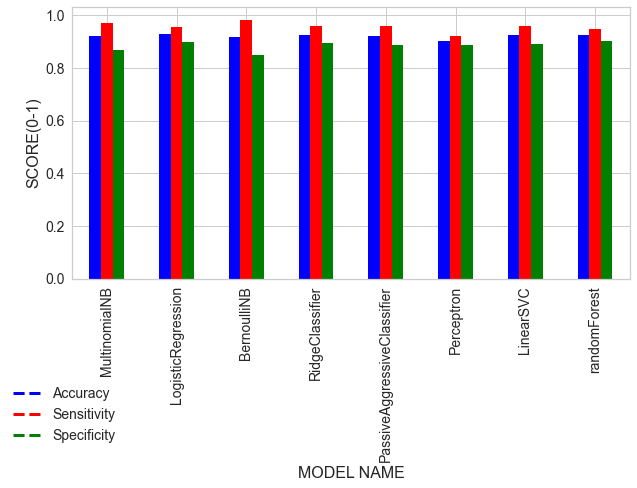

In [380]:

    from matplotlib.lines import Line2D
    locs = ["upper left", "lower left", "center right"]
    ax = result.plot(x="Model", y=["test_accuracy", "test_sensitivity/recall", "test_specificity"], kind="bar",figsize=(10, 5),fontsize=14,color=['blue', 'red', 'green'])
    ax.set_xlabel("MODEL NAME",fontsize=16)
    ax.set_ylabel("SCORE(0-1)",fontsize=16)
    #ax.set_title('Sentiment Analysis Model Comparison',fontsize=20)
    #ax.legend(loc=1, bbox_to_anchor=(0.15,0.01))
    colors = ['blue', 'red', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
    labels = ['Accuracy', 'Sensitivity', 'Specificity']
    plt.legend(lines, labels,loc='center right', bbox_to_anchor=(0.1, -0.5),fontsize=14)
    #plt.legend(lines, labels)